In [1]:
from datetime import *
from xml.dom import minidom
import numpy as np
from random import randint
from inspect import cleandoc as dedent
from struct import *
from struct import unpack
import subprocess
import gzip
from math import *
import time
import sys 
import os
import matplotlib as plt
import matplotlib.patches as patches 
import matplotlib.image as mgimg
from matplotlib import animation
from IPython.display import Video
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches 
from shapely.geometry.polygon import Polygon
import cartopy.feature as cfeature

In [2]:
plt.rcParams.update({'font.size': 12}) 

## Figure 1 a)

In [3]:
# go to directory containing function that loads data and run it
##os.chdir('/Users/ikruse/Documents/GitHub/MCSs')
os.chdir('/home/b/b381460/code/MCSs/')
%run Load_TOOCAN_func.py
%run MCS_functions.py
# go to data (choose region, year)


#os.chdir('/work/bb1166/Irene/')
path = '/work/bb1166/Irene/DataAnalysis/TOOCAN/TOOCAN_v2.06/'
REGION = 'AFRICA'
year=2016
pathyear = path + REGION +'/'+str(year)+'/'
pathtracks = 'FileTracking'
os.chdir(pathyear+pathtracks)
# select a month and load that data 
data = load_TOOCAN('TOOCAN-AFRICA-20160701-20160731.dat') #(JULY)

#select quality data
data = [data[iMCS] for iMCS in np.arange(0, len(data), 1) if(int(data[iMCS].qc_MCS) <= 11108)]

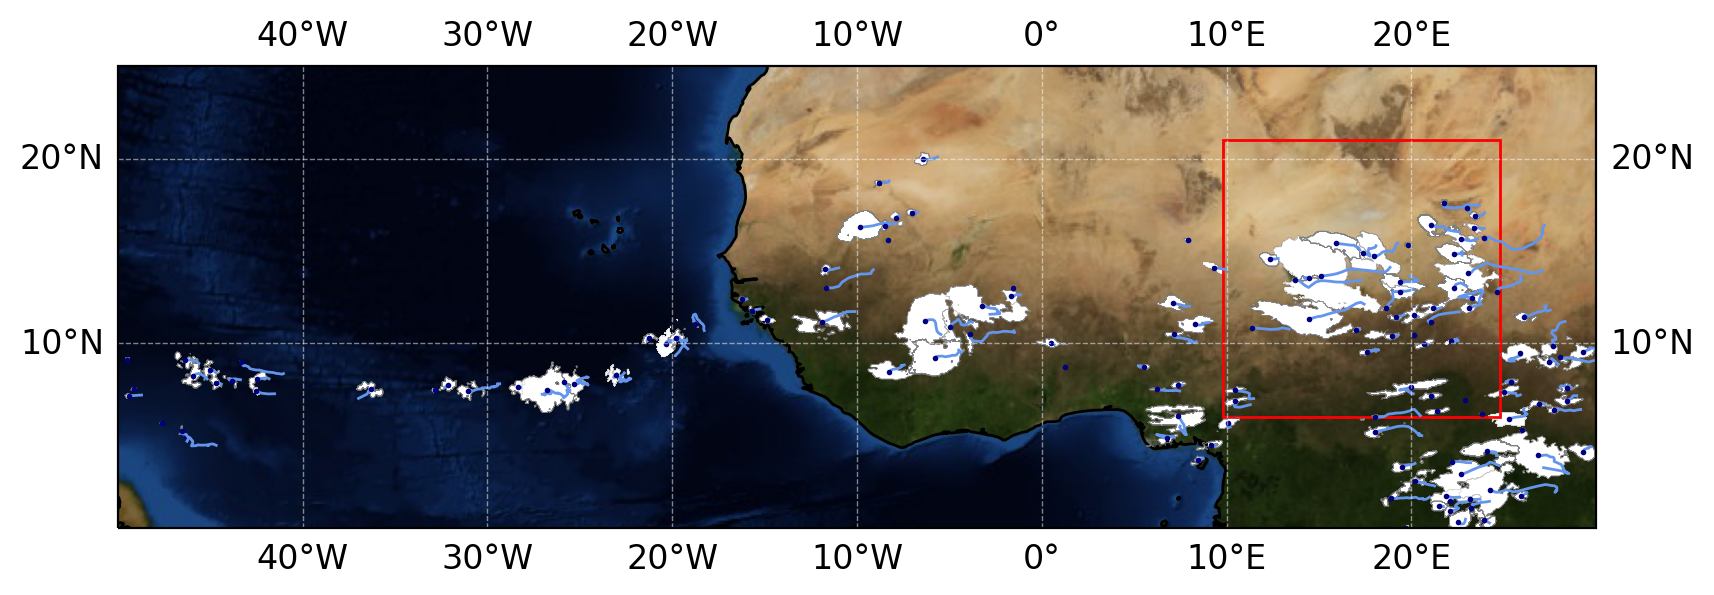

In [4]:
%matplotlib inline

#choose initial day
year = 2016
month = 7

day_init = 14
day= day_init
jday_since1970 = j_day(year,month,day)

pathanim='/Volumes/G-DRIVE/IRENE/animations/'
tabrandom = np.random.randint(255, size=20000000)
tabrandom[0] = -999

lonmin_init=10
latmin_init=6 #10
patchsize=15
slot_init=36
slot_end=37 ##49
vels=[]
lonmin_patch, lonmax_patch, latmin_patch, latmax_patch,vel_x, vel_y, UTC_time, avg_local_time = moving_patch(
    data,year,month,day_init,slot_init,lonmin_init,latmin_init,vels, patchsize, patchsize)

lonmin = -40
lonmax = 40
latmin = -30
latmax = 30

lonmin=-50
lonmax=30
latmin=0
latmax=25

for slot in np.arange(slot_init, slot_end, 1):
    
    lonmin_patch, lonmax_patch, latmin_patch, latmax_patch,vel_x, vel_y, UTC_time, avg_local_time = moving_patch(
    data,year,month,day_init,slot_init,lonmin_patch,latmin_patch,vels, patchsize, patchsize)
    vels.append([vel_x,vel_y])
    
    filesegImages = path+REGION+'/'+str(year)+'/'+str(year)+'_'+str(month).zfill(2)+'_'+str(day).zfill(
        2)+'/ImageSegTOOCAN_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'-'+str(slot).zfill(2)+'.nc'
    ####################################################
    # Open a segmented image produced by TOOCAN
    ####################################################
    (imtoocan, matlon_TOOCAN, matlat_TOOCAN) = open_imsegTOOCAN_NETCDF(filesegImages)
    imtoocan = imtoocan.astype(int)
    imtoocan = imtoocan.data

    ind = np.where((matlon_TOOCAN >= lonmin) & (matlon_TOOCAN <= lonmax) & (
        matlat_TOOCAN >= latmin) & (matlat_TOOCAN <= latmax))

    colmin_TOOCAN = np.min(ind[0])
    colmax_TOOCAN = np.max(ind[0])
    linemin_TOOCAN = np.min(ind[1])
    linemax_TOOCAN = np.max(ind[1])

    imtoocan = imtoocan[colmin_TOOCAN:colmax_TOOCAN +
                        1, linemin_TOOCAN:linemax_TOOCAN+1]
    matlat_TOOCAN = matlat_TOOCAN[colmin_TOOCAN:colmax_TOOCAN +
                                  1, linemin_TOOCAN:linemax_TOOCAN+1]
    matlon_TOOCAN = matlon_TOOCAN[colmin_TOOCAN:colmax_TOOCAN +
                                  1, linemin_TOOCAN:linemax_TOOCAN+1]

    ind = np.where(imtoocan > 0)
    imtoocan2 = np.zeros((np.shape(imtoocan)))
    imtoocan2[ind[0][:], ind[1][:]] = tabrandom[imtoocan[ind[0][:], ind[1][:]]]
    # Mask pixels with a value of zero
    Hmasked = np.ma.masked_where(imtoocan2 <= 0, imtoocan2)
    
    idMCS = [iMCS for iMCS in np.arange(0, len(data), 1) if(int(data[iMCS].Utime_Init) <= jday_since1970 and int(data[iMCS].Utime_End) >= jday_since1970)]


    #######################################################################
    # Selection of the MCS which occured at the given date and at the slot
    #######################################################################
    idMCS_slot = [iMCS for iMCS in np.arange(0, len(idMCS), 1) if(round(
        100*(data[idMCS[iMCS]].Utime_Init - round(data[idMCS[iMCS]].Utime_Init))) == slot)]

    ###################
    # figure
    ###################
    figure = plt.figure(figsize=(10, 3), dpi=200)

    ax = figure.add_subplot(1,1,1, projection=crs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
   
    img = plt.imread('/work/bb1166/Irene/DataAnalysis/TOOCAN/map.jpeg')
    img_extent = (-180, 180, -90, 90)
    ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree()) 
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, 
                  color='white', alpha=0.5, linestyle='--',
                  xlocs=np.arange(-180,180,10), ylocs=np.arange(-180,180,10))

    #ax.add_feature(cfeature.BORDERS)  #if you want countries
    #### Borders of image
    ax.set_extent(
        [
            lonmin, # minimum latitude
            lonmax, # min longitude
            latmin, # max latitude
            latmax # max longitude
        ],
        crs = crs.PlateCarree()
    )
    #### plotting netcdf data

    lons = matlon_TOOCAN
    lats = matlat_TOOCAN
    ax.contourf(lons, lats, Hmasked,
                 transform=crs.PlateCarree(), colors='white', vmin=0, vmax=255)

    ax.contour(lons,lats, imtoocan2, levels=np.arange(255), colors='grey', linewidths=0.01)
    #ax.contour(lons,lats, imtoocan2, levels=np.arange(255), colors='grey', linewidths=0.01)

    rect = patches.Rectangle((lonmin_patch, latmin_patch), 15, 15, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    #########################################################
    # Loop on the number of MCS to plot the MCS trajectories
    #########################################################
    for iMCS in np.arange(0, len(idMCS), 1):

        #######################################################################
        # Selection of the MCS which occured at the given date and at the slot
        #######################################################################
        idslot = [ilife for ilife in np.arange(0, data[idMCS[iMCS]].duration*2, 1, dtype=int) if((round(100*(data[idMCS[iMCS]].clusters.Utime[ilife] - round(
            data[idMCS[iMCS]].clusters.Utime[ilife]))) == slot) & (round(data[idMCS[iMCS]].clusters.Utime[ilife]) == jday_since1970))]

        if(np.size(idslot) > 0):
            lonsclus = data[idMCS[iMCS]].clusters.lon[0:idslot[0]+1]
            latsclus = data[idMCS[iMCS]].clusters.lat[0:idslot[0]+1]
            ax.plot(lonsclus, latsclus, marker='None', color='cornflowerblue', linewidth=1)
            ax.plot(lonsclus[idslot[0]], latsclus[idslot[0]], marker='o', color='navy', markersize=1)

            if(np.size(idslot) > 1):
                import sys
                sys.exit("Error message")
            if(idslot[0] > 0):
                lonsclus = data[idMCS[iMCS]].clusters.lon[idslot[0]-1:idslot[0]+1]
                latsclus = data[idMCS[iMCS]].clusters.lat[idslot[0]-1:idslot[0]+1]



    file = "TOOCAN_"+REGION+'_' + \
    str(year).zfill(4)+str(month).zfill(2) + \
    str(day_init).zfill(2)+"_"+str(slot).zfill(2)+"full.png"
    
    
    ax.set_xlabel('Longitude [degrees]')
    ax.set_ylabel('Latitude [degrees]')
    #plt.savefig(pathanim + file, dpi=200, bbox_inches='tight')
    plt.show()
    
    
    #figure.clf()


## Figure 1 b)

In [6]:
from file_opening_functions import *

DIU_8weeks = open_STAT('RCE_irene_480x480_1km_10s_DIU_sep.nc')
OCEAN_long = open_STAT('RCE_irene_480x480_1km_10s_OCEAN_sep.nc')
Wind_DIU = open_STAT('RCE_irene_1440x480_1km_10s_DIU_Wind.nc')
Wind_OCEAN = open_STAT('RCE_irene_1440x480_1km_10s_OCEAN_Wind.nc')

In [7]:
start_sim = 1008*2
end_sim = 1008*6
DIU_sst = DIU_8weeks.isel(time=slice(start_sim,end_sim)).SST.values.reshape((4*7,144)).mean(axis=0)
OCEAN_sst = OCEAN_long.isel(time=slice(start_sim,end_sim)).SST.values.reshape((4*7,144)).mean(axis=0)

DIU_cldhi = DIU_8weeks.isel(time=slice(start_sim,end_sim)).CLDHI.values.reshape((4*7,144)).mean(axis=0)
DIUwind_cldhi = Wind_DIU.isel(time=slice(start_sim,end_sim)).CLDHI.values.reshape((4*7,144)).mean(axis=0)
OCEAN_cldhi = OCEAN_long.isel(time=slice(start_sim,end_sim)).CLDHI.values.reshape((4*7,144)).mean(axis=0)
OCEANwind_cldhi = Wind_OCEAN.isel(time=slice(start_sim,end_sim)).CLDHI.values.reshape((4*7,144)).mean(axis=0)

DIU_prec= (1/24)*DIU_8weeks.isel(time=slice(start_sim,end_sim)).PREC.values.reshape((4*7,144)).mean(axis=0)
DIUwind_prec = (1/24)*Wind_DIU.isel(time=slice(start_sim,end_sim)).PREC.values.reshape((4*7,144)).mean(axis=0)
OCEAN_prec = (1/24)*OCEAN_long.isel(time=slice(start_sim,end_sim)).PREC.values.reshape((4*7,144)).mean(axis=0)
OCEANwind_prec = (1/24)*Wind_OCEAN.isel(time=slice(start_sim,end_sim)).PREC.values.reshape((4*7,144)).mean(axis=0)


In [8]:
#CHOOSE DATASET PROPERTIES

month=7 #choice: 7 
slot_init=38 #choice: 38 (8pm)
patch_size=15 #choice: 10, 15 (deg)

lonmin_init=10
latmin_init=6 


os.chdir('/work/bb1166/Irene/DataAnalysis/GDRIVE')
mean_skt_land_all = []
mean_mcs_land_all = []
mean_rain_land_all = []
mean_skt_sea_all = []
mean_mcs_sea_all = []
mean_rain_sea_all = []
years=[2012,2013,2014,2015,2016]
days2012=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
days2013=[1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
days2014=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31]
days2015=[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
days2016=[1,2,3,4,5,6,7,8,9,10] #,11,12,13,14,15,16,17,19,20,21,23,24,25,26,27,28,29,30,31] 

days=[days2012,days2013,days2014,days2015,days2016]
for counter in range(5):

    year=years[counter]
    days_init=days[counter]

    mean_skt_land = []
    mean_mcs_land = []
    mean_rain_land = []
    mean_skt_sea = []
    mean_mcs_sea = []
    mean_rain_sea = []

    for day_init in days_init:

        load_path = os.path.join('outputs', 
                                 str(year)+'_'+str(month)+str(day_init)+'_'+str(slot_init)+'_lon'+str(lonmin_init)+'_lat'+str(latmin_init)+'_patch'+str(patch_size)+
                                 'deg_met.npz')   #_new.npz' #_extra.npz)
        datamatrix = np.load(load_path, allow_pickle=True)['datamatrix']
        (mean_skt) = np.load(load_path)['mean_skt']
        (mean_t2m) = np.load(load_path)['mean_t2m']
        (zones) = np.load(load_path)['zones']
        (imerg) = np.load(load_path)['imerg']
        mean_mcs = np.mean(datamatrix, axis=(1,2))
        mean_rain = np.mean(imerg, axis=(1,2))
        mean_mcs_land.append(mean_mcs[0:200])#, mean_mcs[-51:-1]])
        mean_skt_land.append(mean_skt[0:200])#, mean_skt[-51:-1]])
        mean_rain_land.append(mean_rain[0:200])
        first_ocean_timestep=len(mean_skt)
        for timestep in range(len(mean_skt)):
            if ((zones[timestep]==3) and ((timestep+1) % 48 == 0) and ((zones[timestep:timestep+48])==3).all()==True):
                break

        first_ocean_timestep=timestep 

        mean_mcs_sea.append(mean_mcs[first_ocean_timestep:-1])#, mean_mcs[-51:-1]])
        mean_skt_sea.append(mean_skt[first_ocean_timestep:-1])#, mean_skt[-51:-1]])
        mean_rain_sea.append(mean_rain[first_ocean_timestep:-1])

    
    mean_mcs_land_all.append(mean_mcs_land)
    mean_skt_land_all.append(mean_skt_land)
    mean_rain_land_all.append(mean_rain_land)
    
    mean_mcs_sea_all.append(mean_mcs_sea)
    mean_skt_sea_all.append(mean_skt_sea)
    mean_rain_sea_all.append(mean_rain_sea)

In [9]:
allmeans_mcs=[]
allmeans_skt=[]
allstd_mcs=[]
allstd_skt=[]

mean_mcs_land_all_new=[]
mean_skt_land_all_new=[]
mean_rain_land_all_new=[]
for n in range(len(years)):
    year=years[n]
    for counter in range(len(mean_mcs_land_all[n])):
        if (len(mean_mcs_land_all[n][counter])>95 and len(mean_rain_land_all[n][counter])>95):
            mean_mcs_land_all_new.append(mean_mcs_land_all[n][counter][:98])
            mean_skt_land_all_new.append(mean_skt_land_all[n][counter][:98])
            mean_rain_land_all_new.append(mean_rain_land_all[n][counter][:98])
allmeans_mcs=np.mean(mean_mcs_land_all_new, axis=0)
allmeans_skt=np.mean(mean_skt_land_all_new, axis=0)
allmeans_rain=np.mean(mean_rain_land_all_new, axis=0)
allstd_mcs=np.std(mean_mcs_land_all_new, axis=0)
allstd_skt=np.std(mean_skt_land_all_new, axis=0)       
allstd_rain=np.std(mean_rain_land_all_new, axis=0)       

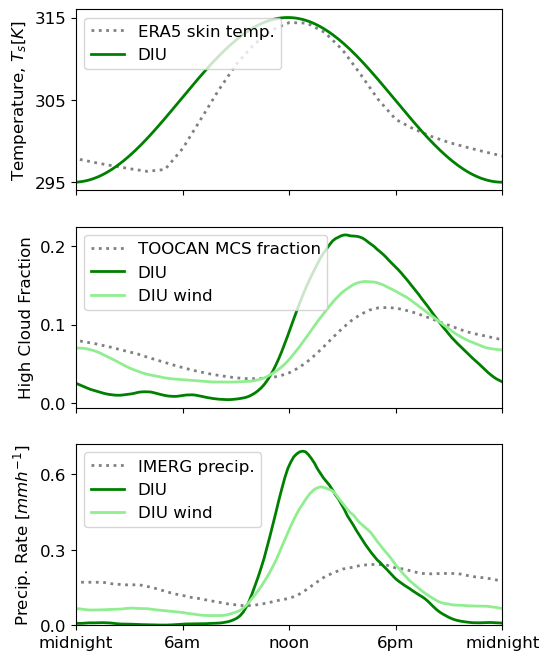

In [10]:
#land
area_boxLagr = (111*15)**2
area_boxSAM =  480**2


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5.5,8), dpi=100, sharex=True)
hours=np.arange(0,96/2+1,0.5)
shift=6
path_deviation = allstd_skt 
smooth_path=  allmeans_skt

ax1.plot(hours[shift::2], smooth_path[shift::2], linewidth=2, color='grey',linestyle=':', label='ERA5 skin temp.')
ax1.plot(np.linspace(shift,shift+24,144),DIU_sst, linewidth=2, color='green',linestyle='-', label='DIU') #, DIU wind')
ax1.set_ylabel('Temperature, $T_s[K]$')
ax1.set_ylim(294,316)
ax1.set_xlim(0,48)
ax1.set_xticks(np.arange(min(hours), max(hours)+1, 24))
ax1.set_yticks(np.linspace(295, 315, 3))
ax1.legend(loc=2)

path_deviation = allstd_mcs 
smooth_path=allmeans_mcs

ax2.plot(hours[shift::], smooth_path[shift::], linewidth=2, color='grey',linestyle=':',label='TOOCAN MCS fraction')
ax2.plot(np.linspace(shift,shift+24,144),DIU_cldhi, linewidth=2, color='green',linestyle='-', label='DIU')
ax2.plot(np.linspace(shift,shift+24,144),DIUwind_cldhi, linewidth=2, color='lightgreen',linestyle='-', label='DIU wind')
ax2.set_ylabel('High Cloud Fraction')
ax2.set_xticks(np.arange(min(hours), max(hours)+1, 24))
ax2.set_xlim(0,48)
ax2.set_yticks(np.linspace(0, 0.2, 3))
ax2.legend()

path_deviation = allstd_rain
smooth_path=allmeans_rain
ax3.plot(hours[shift::], smooth_path[shift::], linewidth=2, color='grey',linestyle=':',label='IMERG precip.')
ax3.plot(np.linspace(shift,shift+24,144),DIU_prec, linewidth=2, color='green',linestyle='-', label='DIU')
ax3.plot(np.linspace(shift,shift+24,144),DIUwind_prec, linewidth=2, color='lightgreen',linestyle='-', label='DIU wind')
ax3.set_ylabel('Precip. Rate $[mm h^{-1}]$')
ax3.set_xticks(np.arange(shift+min(hours), shift+24+1, 6))
ax3.set_yticks(np.linspace(0, 0.6, 3))
ax3.set_xticklabels(['midnight','6am', 'noon', '6pm', 'midnight'])
ax3.set_ylim(0,0.72)
ax3.set_xlim(shift,shift+24)
ax3.legend()
plt.show()




In [11]:
np.mean(allmeans_rain)

0.16516058

In [12]:
allmeans_mcs=[]
allmeans_skt=[]
allstd_mcs=[]
allstd_skt=[]


mean_mcs_sea_all_new=[]
mean_skt_sea_all_new=[]
mean_rain_sea_all_new=[]


for n in range(len(years)):
    year=years[n]
    #if (len(mean_mcs_sea_all[n])>96 and len(mean_skt_sea_all[n])>96): #!!!!! figure out how to do this
    for counter in range(len(mean_mcs_sea_all[n])):
        if (len(mean_mcs_sea_all[n][counter])>95 and len(mean_rain_sea_all[n][counter])>95):
            mean_mcs_sea_all_new.append(mean_mcs_sea_all[n][counter][:98])
            mean_skt_sea_all_new.append(mean_skt_sea_all[n][counter][:98])
            mean_rain_sea_all_new.append(mean_rain_sea_all[n][counter][:98])
    
    
# for n in range(len(years)):    
allmeans_mcs=np.mean(mean_mcs_sea_all_new, axis=0)
allmeans_skt=np.mean(mean_skt_sea_all_new, axis=0)
allmeans_rain=np.mean(mean_rain_sea_all_new, axis=0)
allstd_mcs=np.std(mean_mcs_sea_all_new, axis=0)
allstd_skt=np.std(mean_skt_sea_all_new, axis=0)
allstd_rain=np.std(mean_rain_sea_all_new, axis=0)

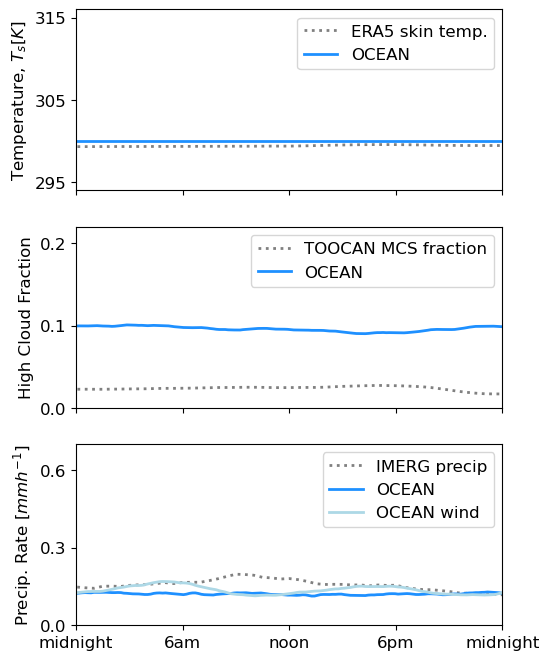

In [13]:
#sea

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5.5,8), dpi=100, sharex=True)
hours=np.arange(0,96/2+1,0.5)
shift=6-2
path_deviation = allstd_skt 
smooth_path=  allmeans_skt

ax1.plot(hours[shift::2], smooth_path[shift::2], linewidth=2, color='grey',linestyle=':', label='ERA5 skin temp.')
ax1.plot(np.linspace(shift,shift+24,144),OCEAN_sst, linewidth=2, color='dodgerblue',linestyle='-', label='OCEAN') #, OCEAN wind')
ax1.set_ylabel('Temperature, $T_s[K]$')
ax1.set_ylim(294,316)
ax1.set_xlim(0,48)
ax1.set_xticks(np.arange(min(hours), max(hours)+1, 24))
ax1.set_yticks(np.linspace(295, 315, 3))
ax1.legend()

path_deviation = allstd_mcs 
smooth_path=allmeans_mcs

ax2.plot(hours[shift::], smooth_path[shift::], linewidth=2, color='grey',linestyle=':',label='TOOCAN MCS fraction')
ax2.plot(np.linspace(shift,shift+24,144),OCEAN_cldhi, linewidth=2, color='dodgerblue',linestyle='-', label='OCEAN')
#ax2.plot(np.linspace(shift,shift+24,144),OCEANwind_cldhi, linewidth=2, color='lightblue',linestyle='-', label='OCEAN wind')
ax2.set_ylabel('High Cloud Fraction')
ax2.set_xticks(np.arange(min(hours), max(hours)+1, 24))
ax2.set_yticks(np.linspace(0, 0.2, 3))
ax2.set_ylim(0,0.22)
ax2.set_xlim(0,48)
ax2.legend()

path_deviation = allstd_rain
smooth_path=allmeans_rain
ax3.plot(hours[shift::], smooth_path[shift::], linewidth=2, color='grey',linestyle=':',label='IMERG precip')
ax3.plot(np.linspace(shift,shift+24,144),OCEAN_prec, linewidth=2, color='dodgerblue',linestyle='-', label='OCEAN')
ax3.plot(np.linspace(shift,shift+24,144),OCEANwind_prec, linewidth=2, color='lightblue',linestyle='-', label='OCEAN wind')
ax3.set_ylabel('Precip. Rate $[mm h^{-1}]$')
ax3.set_xticks(np.arange(shift+min(hours), shift+24+1, 6))
ax3.set_yticks(np.linspace(0, 0.6, 3))
ax3.set_xticklabels(['midnight','6am', 'noon', '6pm', 'midnight'])
ax3.set_ylim(0,0.7)
ax3.set_xlim(shift,shift+24)
ax3.legend()
plt.show()



In [14]:
np.mean(allmeans_rain)

0.14321391

## Figure 1 c)

In [15]:
from file_opening_functions import *

In [16]:
from file_opening_functions import *

DIU_8weeks_2D = open_2D('DIU_long.nc')

OCEAN_long_2D = open_2D('OCEAN_long.nc')

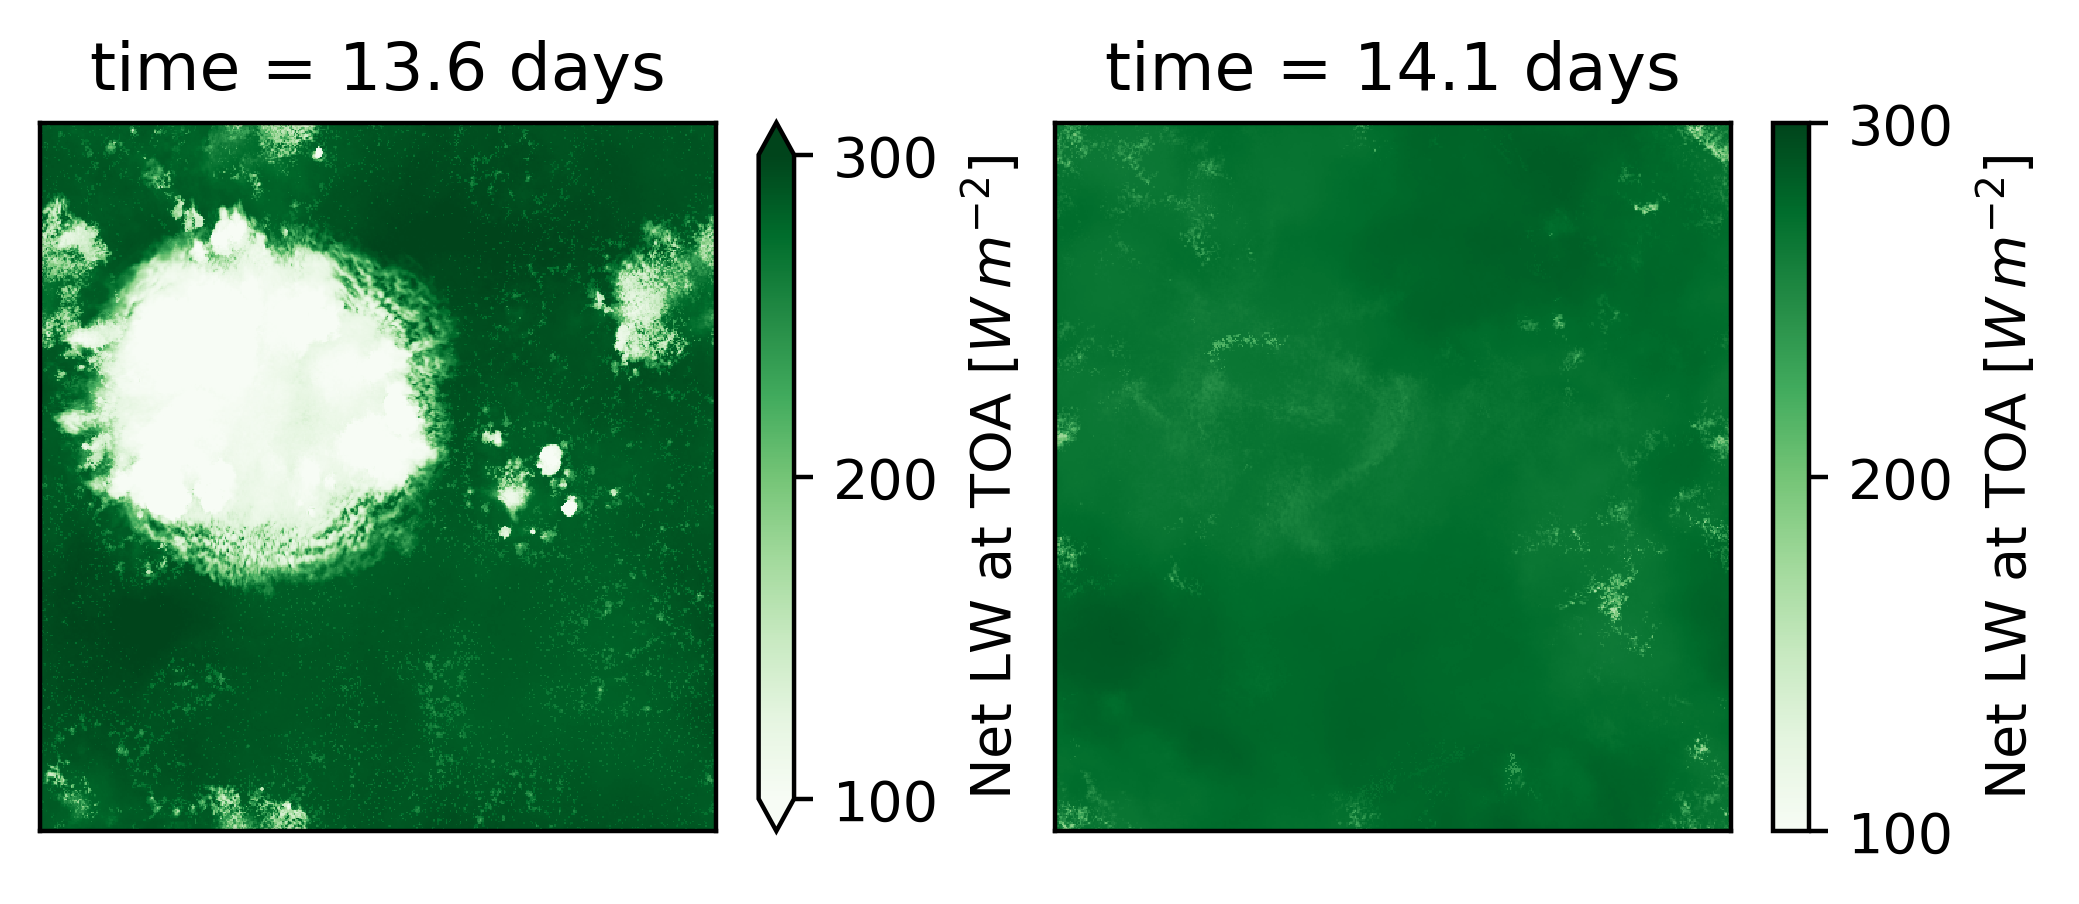

In [17]:
plt.figure(figsize=(6,2.3),dpi=400)
plt.rcParams.update({'font.size': 10})
data=DIU_8weeks_2D
mini=100
maxi=300
cmap='Greens'
ax1= plt.subplot(121)
ax1 = data.LWNT.isel(time=int(144*13.6)).plot(cmap=cmap,vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "Net LW at TOA [$W\,m^{-2}$]","ticks": [100,200,300]})
plt.title('time = 13.6 days')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

ax2= plt.subplot(122)
ax2 = data.LWNT.isel(time=int(144*14.1)).plot(cmap=cmap,vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "Net LW at TOA [$W\,m^{-2}$]","ticks": [100,200,300]})
plt.title('time = 14.1 days')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.savefig('/work/bb1166/Irene/DataAnalysis/Paper1/DIU.png')

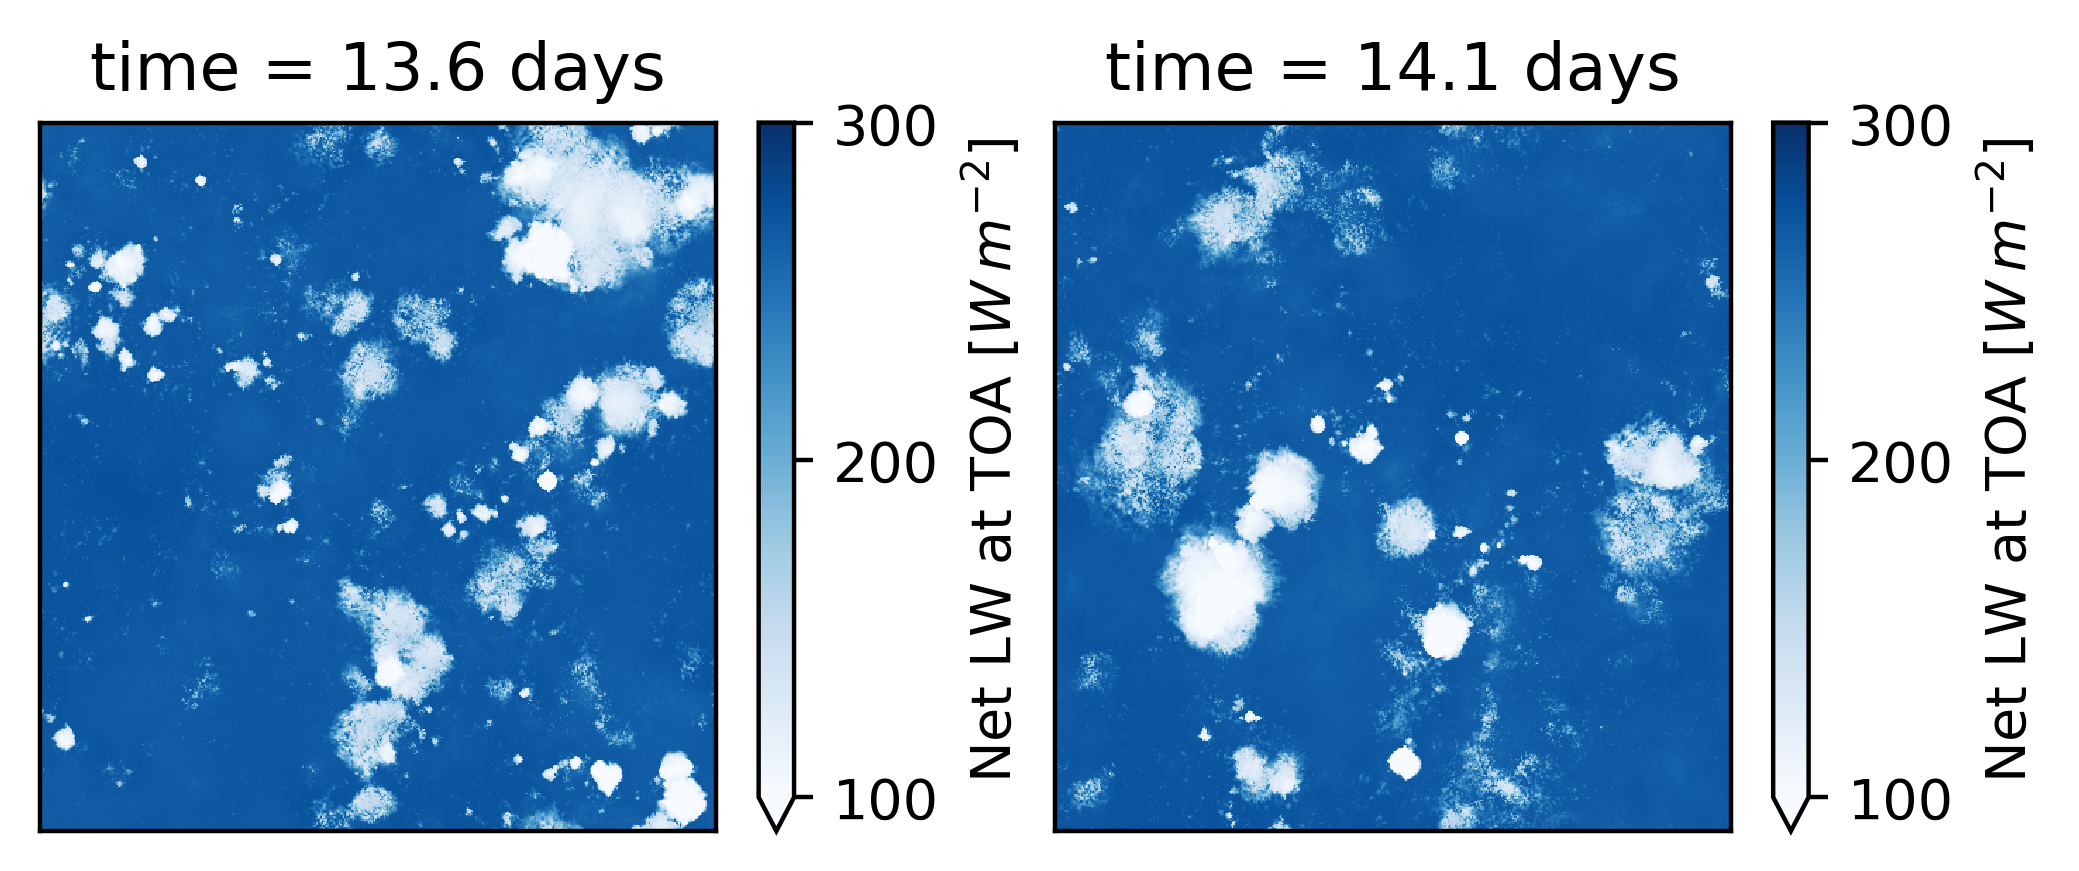

In [18]:
plt.figure(figsize=(6,2.3),dpi=400)
data=OCEAN_long_2D
cmap='Blues'
ax3= plt.subplot(121)
ax3 = data.LWNT.isel(time=int(144*13.6)).plot(cmap=cmap,vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "Net LW at TOA [$W\,m^{-2}$]","ticks": [100,200,300]})
plt.title('time = 13.6 days')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

ax4= plt.subplot(122)
ax4 = data.LWNT.isel(time=int(144*14.1)).plot(cmap=cmap,vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "Net LW at TOA [$W\,m^{-2}$]","ticks": [100,200,300]})
plt.title('time = 14.1 days')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.savefig('/work/bb1166/Irene/DataAnalysis/Paper1/OCEAN.png')
plt.show()

([], [])

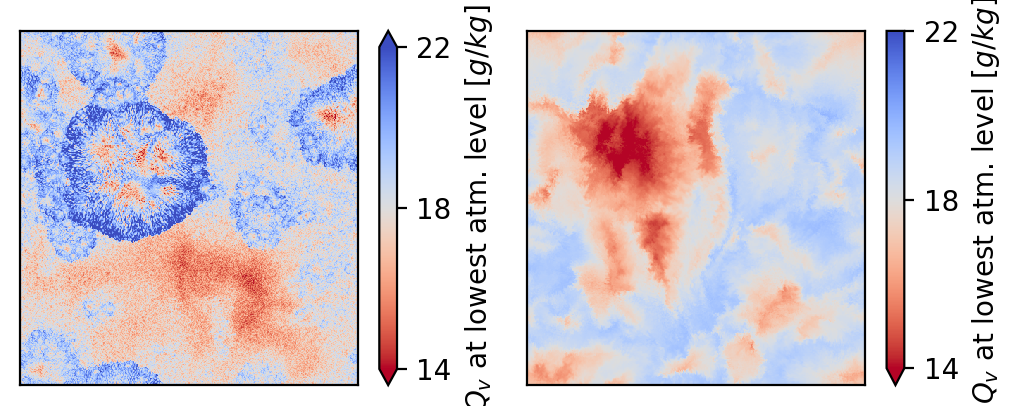

In [19]:
plt.figure(figsize=(6,2.3),dpi=200)
data=DIU_8weeks_2D
mini=14
maxi=22
ax1= plt.subplot(121)
moisture=data.QVSRFC.isel(time=int(144*13.6))*1000
ax1 = moisture.plot(cmap='coolwarm_r',vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "$Q_v$ at lowest atm. level [$g/kg$]","ticks": [14,18,22]})
plt.title('')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])


ax2= plt.subplot(122)
moisture=data.QVSRFC.isel(time=int(144*14.1))*1000
ax2 = moisture.plot(cmap='coolwarm_r',vmin=mini,vmax=maxi,add_colorbar=True,cbar_kwargs={"label": "$Q_v$ at lowest atm. level [$g/kg$]","ticks": [14,18,22]})
plt.title('')
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])





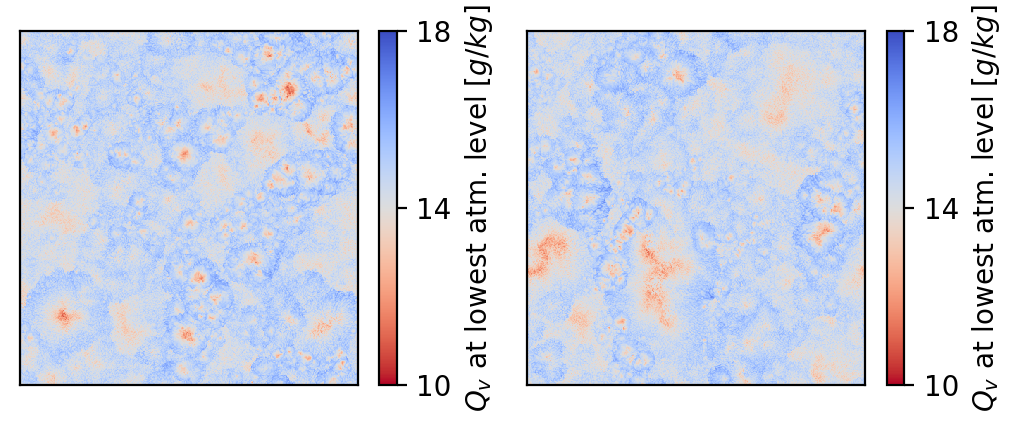

In [20]:
plt.figure(figsize=(6,2.3),dpi=200)

mini=10
maxi=18
data=OCEAN_long_2D
ax3= plt.subplot(121)
moisture=data.QVSRFC.isel(time=int(144*13.6))*1000
ax3 = moisture.plot(cmap='coolwarm_r',vmin=mini,vmax=maxi,add_colorbar=True, cbar_kwargs={"label": "$Q_v$ at lowest atm. level [$g/kg$]","ticks": [10,14,18]})
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

ax4= plt.subplot(122)
moisture=data.QVSRFC.isel(time=int(144*14.1))*1000
ax4 = moisture.plot(cmap='coolwarm_r',vmin=mini,vmax=maxi,add_colorbar=True,cbar_kwargs={"label": "$Q_v$ at lowest atm. level [$g/kg$]","ticks": [10,14,18]})
plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

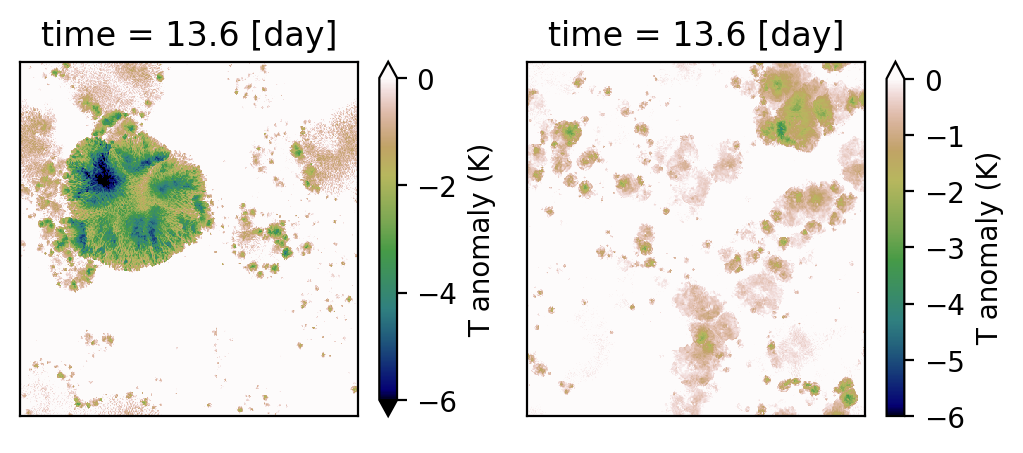

In [115]:

plt.figure(figsize=(6,2.3),dpi=200)
data=DIU_8weeks_2D
mini=-6
maxi=0
ax1= plt.subplot(121)
moisture=data.TSRFC.isel(time=int(144*13.6))-data.TSRFC.isel(time=int(144*13.6)).mean()
ax1 = moisture.plot(cmap='gist_earth',vmin=mini, vmax=maxi, add_colorbar=True, cbar_kwargs={"label":"T anomaly (K)"})

plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

data=OCEAN_long_2D
ax2= plt.subplot(122)
moisture=data.TSRFC.isel(time=int(144*13.6))-data.TSRFC.isel(time=int(144*13.6)).mean()
ax2 = moisture.plot(cmap='gist_earth',vmin=mini, vmax=maxi,add_colorbar=True,cbar_kwargs={"label":"T anomaly (K)"})

plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()




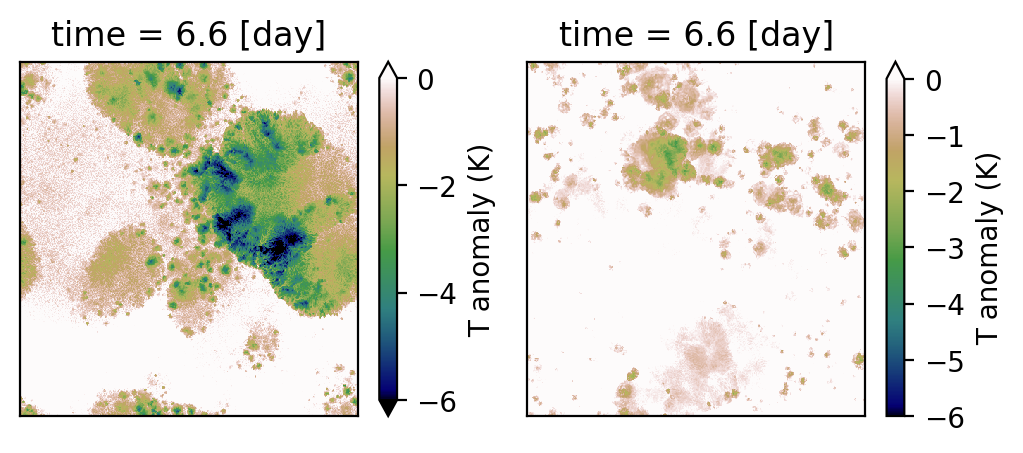

In [124]:
plt.figure(figsize=(6,2.3),dpi=200)
data=DIU_8weeks_2D
mini=-6
maxi=0
ax1= plt.subplot(121)
moisture=data.TSRFC.isel(time=int(144*6.6))-data.TSRFC.isel(time=int(144*13.6)).mean()
ax1 = moisture.plot(cmap='gist_earth',vmin=mini, vmax=maxi, add_colorbar=True, cbar_kwargs={"label":"T anomaly (K)"})

plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('time = 6.6 [day]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

data=OCEAN_long_2D
ax2= plt.subplot(122)
moisture=data.TSRFC.isel(time=int(144*6.6))-data.TSRFC.isel(time=int(144*13.6)).mean()
ax2 = moisture.plot(cmap='gist_earth',vmin=mini, vmax=maxi,add_colorbar=True,cbar_kwargs={"label":"T anomaly (K)"})

plt.xticks(np.arange(0,len(data.x)*1e3,1e5),np.arange(0,len(data.x),1e2))
plt.yticks(np.arange(0,len(data.y)*1e3,1e5),np.arange(0,len(data.y),1e2))
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.title('time = 6.6 [day]')
plt.show()
